In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

## Loading in EVCouplings PFP and natural seqs

In [2]:
import os
import sys

sys.path.append('../pytorch/')
sys.path.append('../pytorch/EVCouplingsStuff/')

In [3]:
# importing the natural sequences

from EVCouplingsGen import *
from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

protein_length =154
is_discrete = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading in EVCouplings model 
focus_seqs = read_fa('../pytorch/EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('../pytorch/EVCouplingsStuff/DYR.model')

# extracting the model parameters used to determine the evolutionary hamiltonian
h = evc_model.h_i
J = evc_model.J_ij
print('actual protein length', h.shape)
if protein_length > 0:
    h = h[0:protein_length, :]
    J = J[0:protein_length, 0:protein_length, :,:]

# processing and plotting the natural sequences: 
# first by converting amino acids into integers and also onehots. 
enc_seqs=[]
oh = []
AA=h.shape[1] # number of amino acids
for seq in focus_seqs['seq']:
    enc_seq = np.asarray(encode_aa(seq, evc_model.alphabet_map))
    if protein_length > 0: 
        enc_seq = enc_seq[:protein_length]
    enc_seqs.append(enc_seq) 
    oh.append(onehot(enc_seq,AA)) # this could be made much more efficient with tensorflow operations. 
enc_seqs = np.asarray(enc_seqs)
natural_oh=np.asarray(oh) # of shape: [batch x L x AA]
N = natural_oh.shape[0] # batch size
L = natural_oh.shape[1] # length of the protein
natural_oh = natural_oh.reshape(-1, L*20)

# loading in the environment class, used to score the evolutionary hamiltonians
gen_model = EVCouplingsGenerator(L, AA, h, J, device, True, gaussian_cov_noise = 10.0)
natural_energies = gen_model.energy(natural_oh)

print('number and dimensions of the oh sequences', natural_oh.shape)


actual protein length (155, 20)
number and dimensions of the oh sequences (7848, 3080)


## Loading in Trajectories

In [4]:
# this is 3K steps for 64 chains of 154 length. 
directory = '../pytorch/experiments/protein_lengthFull_50K_steps_datetime_2020-04-16_20_42_54.072825/'
# this is length 6, 50K steps for 64 chains. 
#'../pytorch/experiments/protein_length6_datetime_2020-04-16_18_06_50.702275/'

In [5]:
reader = pd.read_csv(directory+'hill_climb_trajectories.txt',
                     sep=' ', header=None,
                     chunksize=10000)

total_size = 0
first_done = False

for c in reader:
    print(c.shape)
    total_size+=c.shape[0]
    print(total_size)
    if first_done == False: 
        
        sequences = c.loc[:,0:(L*20 -1)].values.astype(np.uint)
        energies = c[(L*20)].values
        
        first_done=True
    else: 
        sequences = np.vstack( [sequences, c.loc[:,0:(L*20 -1)].values.astype(np.uint) ] )
        energies = np.hstack( [energies, c[(L*20)].values])
        
print('total size of new file is: ', total_size)

(10000, 3081)
10000
(10000, 3081)
20000
(10000, 3081)
30000
(10000, 3081)
40000
(10000, 3081)
50000
(10000, 3081)
60000
(10000, 3081)
70000
(10000, 3081)
80000
(10000, 3081)
90000
(10000, 3081)
100000
(10000, 3081)
110000
(10000, 3081)
120000
(10000, 3081)
130000
(10000, 3081)
140000
(10000, 3081)
150000
(10000, 3081)
160000
(10000, 3081)
170000
(10000, 3081)
180000
(10000, 3081)
190000
(2000, 3081)
192000
total size of new file is:  192000


In [7]:
energies.shape

(192000,)

In [8]:
import pickle 
import gzip
np.savetxt( open(directory+'hill_climb_trajectories_seqs.txt', 'w'), sequences )
np.savetxt(open(directory+'hill_climb_trajectories_energies.txt', 'w'), energies )

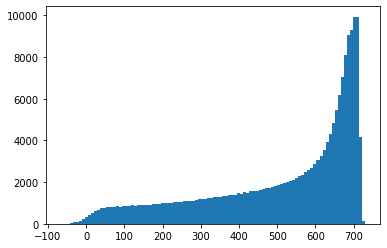

In [9]:
%matplotlib inline
plt.hist(energies, bins=100)
plt.show()

In [16]:
np.where(sequences[0]==1.0)[0]

array([  16,   30,   53,   69,   82,  106,  131,  154,  173,  188,  206,
        225,  258,  277,  289,  302,  320,  357,  364,  395,  415,  435,
        443,  460,  496,  515,  528,  548,  569,  583,  611,  624,  659,
        662,  687,  708,  720,  741,  767,  794,  803,  835,  846,  871,
        892,  902,  936,  946,  965,  990, 1006, 1021, 1047, 1062, 1098,
       1106, 1122, 1145, 1172, 1180, 1210, 1224, 1244, 1272, 1297, 1304,
       1338, 1340, 1367, 1389, 1404, 1426, 1448, 1478, 1492, 1516, 1532,
       1559, 1567, 1594, 1619, 1635, 1647, 1678, 1698, 1715, 1732, 1755,
       1763, 1788, 1804, 1831, 1859, 1865, 1894, 1901, 1936, 1952, 1963,
       1992, 2018, 2025, 2046, 2068, 2099, 2118, 2121, 2141, 2170, 2197,
       2200, 2220, 2245, 2272, 2283, 2304, 2328, 2355, 2370, 2388, 2419,
       2423, 2458, 2471, 2480, 2515, 2533, 2547, 2569, 2586, 2607, 2625,
       2646, 2672, 2690, 2715, 2734, 2757, 2772, 2789, 2819, 2837, 2849,
       2879, 2890, 2916, 2924, 2940, 2962, 2998, 30

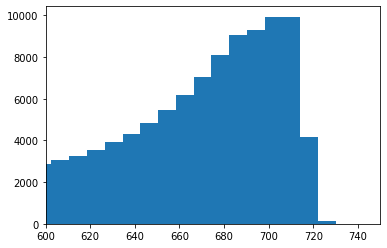

In [24]:
plt.xlim(600,750)
plt.hist(energies, bins=100)
plt.show()

In [19]:
energies.shape

(192000,)

In [28]:
sequences.shape

(192000, 3080)

In [29]:
# how many unique sequences are there? for the trajectory as a whole 
sequences_unique = np.unique(sequences, axis=0)
sequences_unique.shape

(191948, 3080)

## UMAP plots

In [25]:
to_u = np.vstack([sequences, natural_oh])
u_energies = np.hstack([energies, natural_energies])


In [26]:
import umap
reducer = umap.UMAP()
reducer.fit(to_u)
embedding = reducer.transform(to_u)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/uma

In [30]:
natural_energies.mean()

651.0547065786972

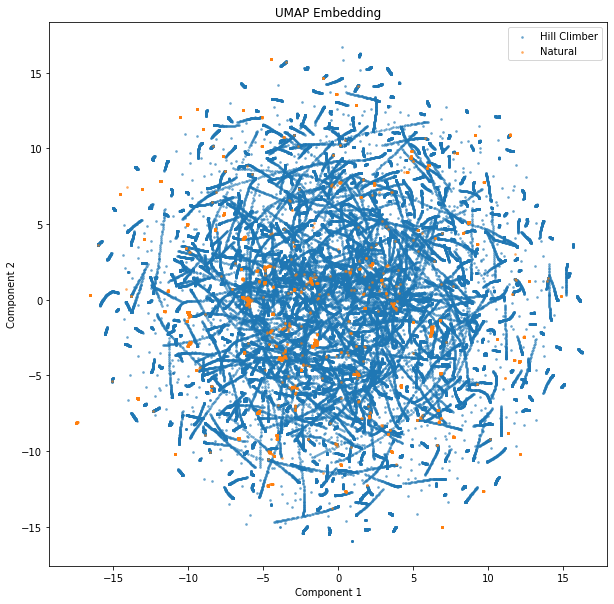

In [31]:
E = 650
plt.scatter(embedding[0:len(sequences), 0][energies>E], embedding[0:len(sequences), 1][energies>E], s=3, alpha=0.5, label='Hill Climber')
plt.scatter(embedding[len(sequences):, 0][natural_energies>E], embedding[len(sequences):, 1][natural_energies>E], s=3, alpha=0.5, label='Natural')
#plt.scatter(embedding[num_gen*2:, 0][nat_energies>E], embedding[num_gen*2:, 1][nat_energies>E], s=3, alpha=0.3, label='Natural')
plt.gcf().set_size_inches(10,10)

plt.title('UMAP Embedding')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
#plt.gcf().savefig('../notebooks/figs/UMAP_Cont_Full_rerun.png', dpi=250)
plt.show()

In [32]:
u_energies.shape

(199848,)

In [33]:
len(sequences)

192000

In [34]:
embedding.shape

(199848, 2)

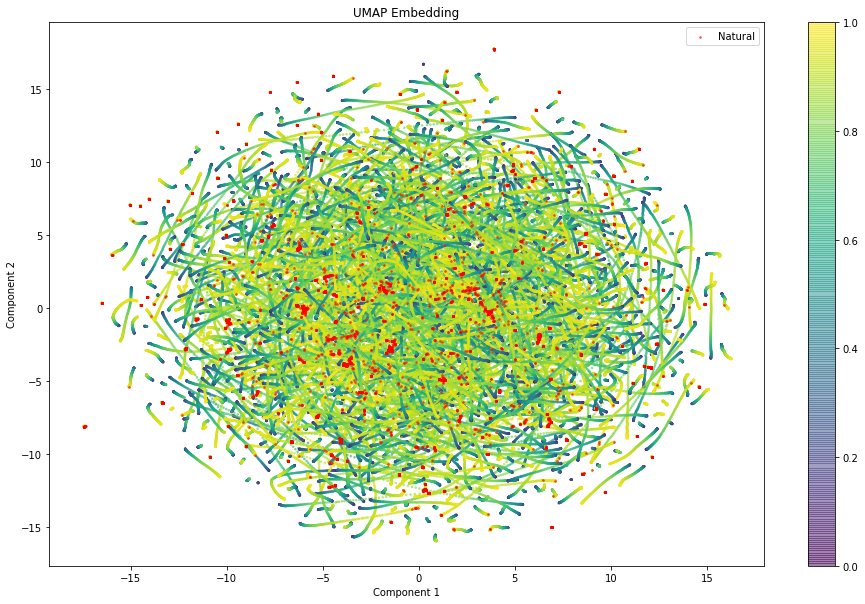

In [37]:


E = -100
plt.scatter(embedding[:, 0][u_energies>E], embedding[:, 1][u_energies>E], s=3, c=u_energies[u_energies>E], alpha=0.5)
plt.scatter(embedding[len(sequences):, 0][natural_energies>E], embedding[len(sequences):, 1][natural_energies>E], s=3, color='red', alpha=0.5, label='Natural')
#plt.scatter(embedding[len(sequences):, 0][natural_energies>E], embedding[len(sequences):, 1][natural_energies>E], s=3, c=u_energies[len(sequences):], alpha=0.5, label='Natural')
#plt.scatter(embedding[num_gen*2:, 0][nat_energies>E], embedding[num_gen*2:, 1][nat_energies>E], s=3, alpha=0.3, label='Natural')
plt.gcf().set_size_inches(16,10)

plt.title('UMAP Embedding')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.legend()
#plt.gcf().savefig('../notebooks/figs/UMAP_Cont_Full_rerun.png', dpi=250)
plt.show()

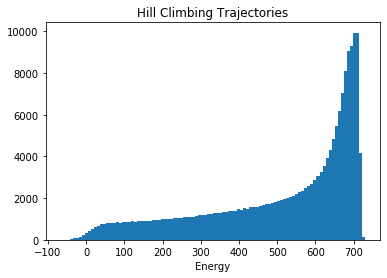

In [38]:
plt.hist(energies, bins=100)
plt.title('Hill Climbing Trajectories')
plt.xlabel('Energy')
plt.show()

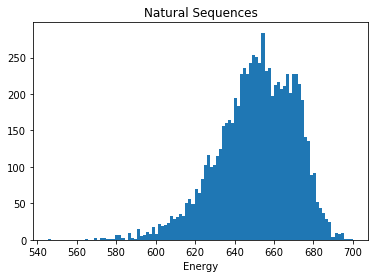

In [39]:
plt.hist(natural_energies, bins=100)
plt.title('Natural Sequences')
plt.xlabel('Energy')
plt.show()

## Loading in the local maxima found

In [40]:
# how many local maxima were found and where are they? 
# this is stored as a tuple of (sequence, energy)
local_maxes = pickle.load( open(directory+'local_maxes_and_energies.pickle', 'rb'))

In [41]:
len(local_maxes)

896

In [42]:
max_sequences = []
max_energies = []
for l in local_maxes: 
    max_sequences.append(l[0])
    max_energies.append(l[1][0])
max_sequences= np.asarray(max_sequences)

In [43]:
max_energies[0]

681.9856368351029

In [44]:
max_sequences[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
len(max_sequences)

896

In [96]:
# how many unique sequences are there? for the maxima
max_sequences_unique, max_unique_inds = np.unique(max_sequences, axis=0, return_index=True)
max_energies_unique = np.asarray(max_energies)[max_unique_inds]
max_sequences_unique.shape

(64, 3080)

In [94]:
max_unique_ind

array([56, 48,  4, 32,  5, 40, 38, 44, 20, 18,  8, 36, 63, 34, 25, 52, 57,
        9, 28, 61, 49, 23, 37, 39,  7, 55, 53,  0, 45, 19, 54, 58, 15, 47,
       42, 35, 46, 62, 17, 31, 59, 30, 43, 27, 24, 41, 13,  1,  2, 16, 26,
        6, 10, 51, 33, 21, 12, 11, 22,  3, 50, 60, 14, 29])

In [ ]:
# what do all of these unique sequences collapse into? 



In [47]:
len(sequences)

192000

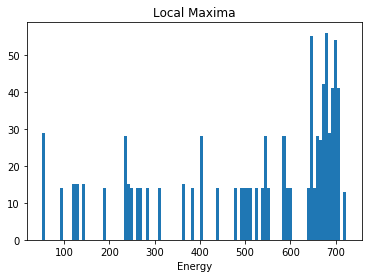

In [48]:
plt.hist(max_energies, bins=100)
plt.xlabel('Energy')
plt.title('Local Maxima')
plt.show()

In [72]:
np.max(max_energies)

723.9818475777065

## Hardmax to be able to do diversity analysis

In [49]:
# creating a hardmax version of the hill climb

def hard_max(inp):
    if inp.shape[1] > L: # if it isnt a sequence of ints, then all to .  
        #print('the input to oh is', inp)

        if len(inp)>2:
            inp = inp.reshape(inp.shape[0], -1, 20)
        else:
            inp = inp.reshape(-1,20)

        inp = np.argmax(inp, axis=-1)
    return inp

sequences_hard = hard_max(sequences)
sequences_hard.shape

(192000, 154)

In [84]:
max_sequences_hard = hard_max(max_sequences)
max_sequences_hard.shape

(896, 154)

## What do the unique sequences collapse into? 

In [85]:
# what do all of the unique sequences collapse into??
counter = dict()
energies_counter = dict()
for i in range(len(max_sequences_hard)):
    seq = tuple(max_sequences_hard[i])
    if seq in counter.keys(): 
        counter[seq] +=1
    else:
        counter[seq] = 1
        energies_counter[seq] = max_energies[i]

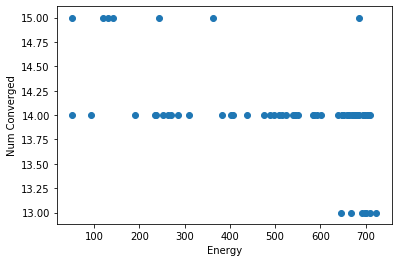

In [92]:
num_converged = []
energy_of_converged = []
for k, v in counter.items():
    num_converged.append(v)
    energy_of_converged.append(energies_counter[k])
    
plt.scatter(energy_of_converged, num_converged)
plt.xlabel('Energy')
plt.ylabel('Num Converged')
plt.show()

## Hamming distance analysis

========= showing!  Hill Climb
selecting  200  for faster computation
(200, 200)
mean hamming 0.7137045454545454


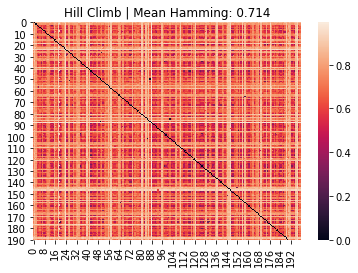

========= showing!  Local Maxima
selecting  200  for faster computation
(200, 200)
mean hamming 0.7318003246753247


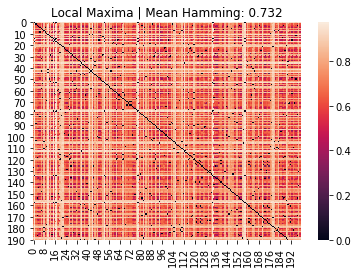

========= showing!  Natural Sequences
selecting  200  for faster computation
(200, 200)
mean hamming 0.5999769480519481


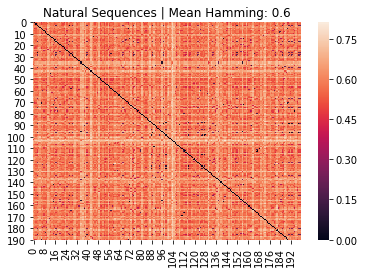

In [51]:
from scipy.spatial.distance import hamming, pdist, squareform

n_rand =200
names = ['Hill Climb', 'Local Maxima', 'Natural Sequences']

for data, n in zip([sequences_hard, max_sequences_hard, enc_seqs], names):
    print('========= showing! ', n)
    plt.figure()
    print('selecting ', n_rand,' for faster computation')
    rand_inds =np.random.choice(np.arange(data.shape[0]), n_rand, replace=False)
    data = data[rand_inds, :]
    
    ham = squareform(pdist(data, hamming))
    print(ham.shape)
    print('mean hamming', ham.mean())
    sns.heatmap(ham)
    plt.title(n +' | Mean Hamming: '+str(round(ham.mean(), 3)))
    plt.show()
    #plt.gcf().savefig('../notebooks/figs/HammingDist_'+n.split(' ')[-1]+'_Len6.png', dpi=250)
    

In [52]:
unq_embedding = reducer.transform(max_sequences_unique)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap

In [53]:
unq_embedding.shape

(64, 2)

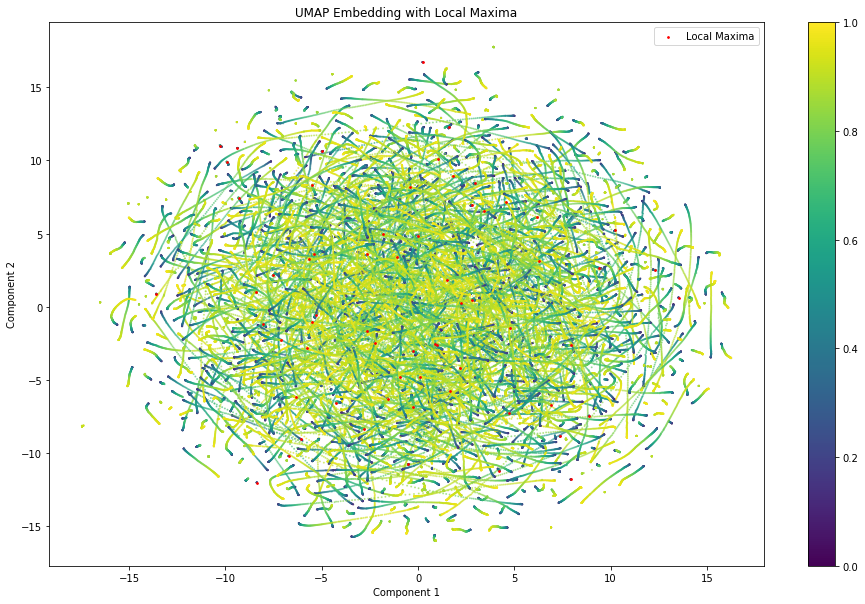

In [65]:
E = -650
plt.scatter(embedding[:, 0][u_energies>E], embedding[:, 1][u_energies>E], 
            s=1, c=u_energies[u_energies>E], alpha=0.5)
#plt.scatter(embedding[len(sequences):, 0][natural_energies>E], embedding[len(sequences):, 1][natural_energies>E], 
#            s=1, color='red', alpha=0.3, label='Natural')
plt.scatter(unq_embedding[:,0], unq_embedding[:,1], s=3, color='red', alpha=1.0, label='Local Maxima')
plt.gcf().set_size_inches(16,10)

plt.title('UMAP Embedding')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.legend()
plt.title('UMAP Embedding with Local Maxima')
#plt.gcf().savefig('../notebooks/figs/UMAP_Cont_Full_rerun.png', dpi=250)
plt.show()

In [66]:
max_sequences_hard_unique = np.unique(max_sequences_hard, axis=0)
max_sequences_hard_unique.shape

(64, 154)

In [67]:
enc_seqs.shape

(7848, 154)

In [68]:
natural_hard_unique = np.unique(enc_seqs, axis=0)
natural_hard_unique.shape

(7568, 154)

(array([ 43.,  45.,  71.,  56.,  29.,  42.,  70.,  98., 111., 331.]),
 array([ 51.32972508, 118.59493733, 185.86014958, 253.12536183,
        320.39057408, 387.65578633, 454.92099858, 522.18621083,
        589.45142308, 656.71663533, 723.98184758]),
 <a list of 10 Patch objects>)

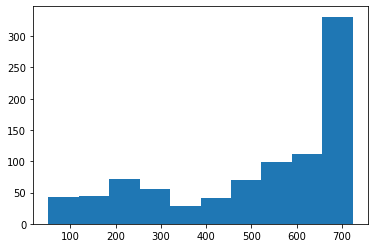

In [90]:
plt.hist(max_energies)

In [97]:
max_energies_unique

array([236.4616076 , 685.28774119, 243.95327734, 586.99878645,
       700.68969637, 695.71438221, 670.25764257, 543.19701214,
       189.81649026, 252.8294465 , 310.42434451, 525.19392898,
       723.98184758, 438.35961896, 538.63316029, 644.73765084,
       694.58573032, 685.36592505, 709.08462845, 693.01715031,
       649.91548412, 703.24636934, 710.40582563, 697.56659183,
       515.20426574, 668.29134061, 675.50535759, 681.98563684,
       699.03273119, 705.07706641, 584.88342566, 648.24997821,
       661.08296146, 131.47422204, 544.57930417, 663.89908144,
       496.69563474, 476.51677892, 678.18030528, 284.64368796,
       262.42111419,  94.2379134 , 488.76390955, 649.35080522,
       651.03978858, 671.5266727 , 658.85545268, 550.96871053,
       507.83334667, 382.93227375, 592.8542357 , 602.56867997,
       677.73748482, 363.7560567 , 407.50709952, 269.27863005,
        52.28113203, 141.47161525, 119.87311436,  51.32972508,
       233.76480036, 401.76131655, 639.59880814, 679.78

In [98]:
# find what the nearest natural sequence is for each of the local optima
to_df = []
E = 600
for i in range(len(max_sequences_hard_unique)):
    if max_energies_unique[i] < E:
        continue
    hamms = 1 - ((natural_hard_unique == max_sequences_hard_unique[i]).sum(1) / sequences_hard.shape[1])
    minn = np.min(hamms)
    num_unique_seqs_same_dist = (hamms==minn).sum()
    to_df.append( [max_sequences_hard_unique[i], minn, num_unique_seqs_same_dist])
closest_natural = pd.DataFrame(to_df)
closest_natural.columns = ['local_min', 'min_hamm', 'number_unique_at_min_ham']

In [99]:
closest_natural.head()

,local_min,min_hamm,number_unique_at_min_ham
0,"[0, 10, 7, 0, 0, 17, 0, 11, 11, 5, 17, 7, 5, 1...",0.474026,1
1,"[2, 16, 11, 4, 12, 1, 11, 13, 14, 18, 10, 18, ...",0.876623,5
2,"[3, 2, 7, 0, 2, 17, 2, 18, 10, 10, 1, 4, 5, 5,...",0.837662,2
3,"[3, 9, 7, 9, 11, 18, 12, 14, 1, 12, 16, 7, 5, ...",0.805195,2
4,"[6, 10, 7, 0, 0, 10, 16, 14, 3, 14, 17, 7, 5, ...",0.512987,1


Text(0.5, 1.0, 'Hamming Dist of Local Maxima to Nearest Natural Seq | E above 600')

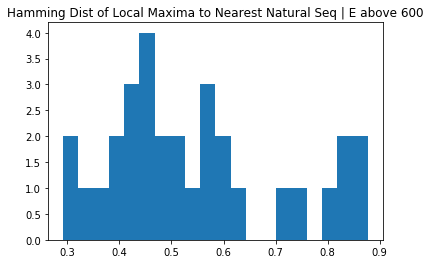

In [101]:
plt.hist(closest_natural.min_hamm, bins=20)
plt.title('Hamming Dist of Local Maxima to Nearest Natural Seq | E above '+str(E))

### looking at the very first results for the full length protein

how many unique sequences? 44 44


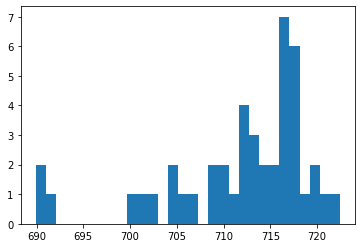

In [73]:


lol = '[(array([0., 0., 0., ..., 0., 0., 0.]), 716.0848649167965), (array([0., 0., 0., ..., 0., 0., 0.]), 717.8165762890858), (array([1., 0., 0., ..., 0., 0., 0.]), 712.6364948165428), (array([0., 0., 0., ..., 0., 0., 0.]), 717.8021011580277), (array([0., 0., 0., ..., 0., 0., 0.]), 713.7931787988055), (array([0., 0., 0., ..., 0., 0., 0.]), 711.7186967601592), (array([1., 0., 0., ..., 0., 0., 0.]), 714.9568837830957), (array([0., 0., 0., ..., 0., 0., 0.]), 719.1895712620244), (array([0., 0., 0., ..., 0., 0., 0.]), 716.555814121406), (array([0., 0., 0., ..., 0., 0., 0.]), 704.2148441982863), (array([0., 0., 0., ..., 0., 0., 0.]), 689.9233432275314), (array([0., 0., 0., ..., 0., 0., 0.]), 716.4127864086113), (array([0., 0., 0., ..., 0., 0., 0.]), 712.1865501563225), (array([1., 0., 0., ..., 0., 0., 0.]), 717.6645428277407), (array([0., 0., 0., ..., 0., 0., 0.]), 699.9986923534943), (array([0., 0., 0., ..., 0., 0., 0.]), 713.4442057197884), (array([0., 0., 0., ..., 0., 0., 0.]), 716.7817100984539), (array([1., 0., 0., ..., 0., 0., 0.]), 711.1128311009525), (array([0., 0., 0., ..., 0., 0., 0.]), 712.6453760537406), (array([0., 0., 0., ..., 0., 0., 0.]), 720.585943748607), (array([0., 0., 0., ..., 0., 0., 0.]), 707.071078202207), (array([0., 0., 0., ..., 0., 0., 0.]), 716.5528613247734), (array([1., 0., 0., ..., 0., 0., 0.]), 705.1814378710405), (array([0., 0., 0., ..., 0., 0., 0.]), 690.5247212688437), (array([0., 0., 0., ..., 0., 0., 0.]), 709.7769679008707), (array([0., 0., 0., ..., 0., 0., 0.]), 716.7183428301432), (array([0., 0., 0., ..., 0., 0., 0.]), 702.1408906499273), (array([1., 0., 0., ..., 0., 0., 0.]), 710.11033891447), (array([0., 0., 0., ..., 0., 0., 0.]), 717.453337670544), (array([0., 0., 0., ..., 0., 0., 0.]), 713.7020774582634), (array([0., 0., 0., ..., 0., 0., 0.]), 709.0677025356417), (array([0., 0., 0., ..., 0., 0., 0.]), 715.8272422041046), (array([1., 0., 0., ..., 0., 0., 0.]), 701.7888836044367), (array([0., 0., 0., ..., 0., 0., 0.]), 716.7422715835346), (array([0., 0., 0., ..., 0., 0., 0.]), 691.8363993833627), (array([0., 0., 0., ..., 0., 0., 0.]), 717.1766071327438), (array([0., 0., 0., ..., 0., 0., 0.]), 714.5605184007873), (array([1., 0., 0., ..., 0., 0., 0.]), 717.6871780730289), (array([0., 0., 0., ..., 0., 0., 0.]), 722.4692416645703), (array([0., 0., 0., ..., 0., 0., 0.]), 704.8532939322831), (array([0., 0., 0., ..., 0., 0., 0.]), 720.2534265476424), (array([0., 0., 0., ..., 0., 0., 0.]), 719.61113102332), (array([0., 0., 0., ..., 0., 0., 0.]), 708.6662308749655), (array([0., 0., 0., ..., 0., 0., 0.]), 713.340015514128), (array([1., 0., 0., ..., 0., 0., 0.]), 717.6163892411496)]'
scores = []
for s in lol.split(', '):
    if s[-1]==')' and len(s)>15:
        scores.append(float(s[:-1]))
        
print('how many unique sequences?', len(scores), len(list(set(scores))) )

plt.hist(scores, bins=30)
plt.show()

In [74]:
np.max(scores)

722.4692416645703